In [ ]:
!pip install keras==2.2.4

In [ ]:
!pip install tensorflow_datasets

In [ ]:
!pip install ipywidgets

In [ ]:
!pip install --upgrade jupyter

In [1]:
import os
os.environ['TF_KERAS'] = '1'
import tensorflow as tf
import keras
import keras.backend as K
import time

Using TensorFlow backend.


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  3


## Configuration File

In [3]:
IMG_SIZE = 256
NUM_CHANNELS = 3
BATCH_SIZE = 64
LR = 3e-5
EPSILON=1e-08
USE_AMP=True

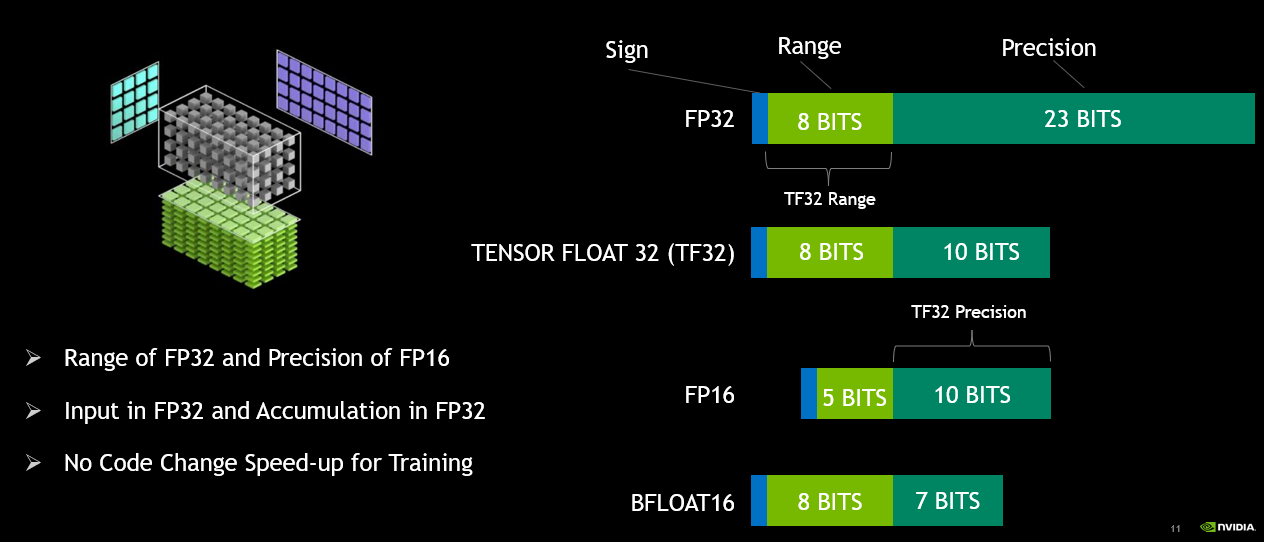

## Enable XLA & Mixed Precision & Eager Execution

In [4]:
if USE_AMP:
    tf.config.optimizer.set_jit(True)
    tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
    TF_DTYPE = tf.float16
else:
    TF_DTYPE = tf.float32

In [5]:
import tensorflow_datasets as tfds

## Callback

In [6]:
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [7]:
time_callback = TimeHistory()

## Load  Dataset

In [8]:
(ds_train,ds_validation, ds_test),ds_info = tfds.load('imagenette', split=['train[:80%]', 'train[80%:]', 'validation'],with_info=True,as_supervised=True)

In [9]:
print(ds_info)

tfds.core.DatasetInfo(
    name='imagenette',
    version=0.1.0,
    description='Imagenette is a subset of 10 easily classified classes from the Imagenet
dataset. It was originally prepared by Jeremy Howard of FastAI. The objective
behind putting together a small version of the Imagenet dataset was mainly
because running new ideas/algorithms/experiments on the whole Imagenet take a
lot of time.

This version of the dataset allows researchers/practitioners to quickly try out
ideas and share with others. The dataset comes in three variants:

  * Full size
  * 320 px
  * 160 px

Note: The v2 config correspond to the new 70/30 train/valid split (released
in Dec 6 2019).',
    homepage='https://github.com/fastai/imagenette',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=13394,
    splits={
        'train': 9469,
        'validation': 3925,
    }

## Preprocessing

In [10]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return tf.cast(image, TF_DTYPE) / 255., label

In [11]:
tf.random.set_random_seed(42)

In [12]:
#Data Loader --> [Images,Label] --> ([BATCH_SIZE,H,W,C],[BATCH_SIZE,NUMBER_CLASSES])

## Training Dataset Pipeline 

In [13]:
ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
# For true randomness, we set the shuffle buffer to the full dataset size.
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples).repeat()
# Batch after shuffling to get unique batches at each epoch.
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Evaluation Dataset Pipeline

In [14]:
ds_validation = ds_validation.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_validation = ds_validation.cache()
ds_validation = ds_validation.batch(BATCH_SIZE)
ds_validation = ds_validation.prefetch(tf.data.experimental.AUTOTUNE)

## Testing Dataset Pipeline

In [15]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).repeat()
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

## Select a pre-trained model 

In [16]:
INPUT_SHAPE = (IMG_SIZE,IMG_SIZE,3)

In [17]:
model = tf.keras.applications.ResNet50(input_shape=INPUT_SHAPE,include_top=False, weights=None)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [18]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(10)


In [20]:
model = tf.keras.Sequential([
  model,
  global_average_layer,
  prediction_layer
])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________


In [22]:
opt = tf.keras.optimizers.Adam(learning_rate=LR, epsilon=EPSILON)
if USE_AMP:
    opt = tf.train.experimental.enable_mixed_precision_graph_rewrite(opt)

In [23]:
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
steps_per_epoch = int(int(12894 * 0.8) / BATCH_SIZE) + 1
validation_steps = int(int(500 / BATCH_SIZE)) + 1

In [25]:
steps_per_epoch

162

In [28]:
162/8

20.25

In [26]:
history = model.fit(ds_train,
                    epochs=5,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=ds_test, validation_steps=validation_steps,
                   callbacks=[time_callback])

Train on 162 steps, validate on 8 steps
Epoch 1/5
162/162 [==============================] - 85s 524ms/step - loss: 2.0010 - acc: 0.2970 - val_loss: 3.5958 - val_acc: 0.0957
Epoch 2/5
162/162 [==============================] - 37s 227ms/step - loss: 1.6784 - acc: 0.4213 - val_loss: 5.4632 - val_acc: 0.0938
Epoch 3/5
162/162 [==============================] - 37s 228ms/step - loss: 1.4695 - acc: 0.4975 - val_loss: 2.8088 - val_acc: 0.2129
Epoch 4/5
162/162 [==============================] - 37s 227ms/step - loss: 1.2994 - acc: 0.5563 - val_loss: 2.1236 - val_acc: 0.3633
Epoch 5/5
162/162 [==============================] - 37s 227ms/step - loss: 1.2018 - acc: 0.5965 - val_loss: 1.5148 - val_acc: 0.4844


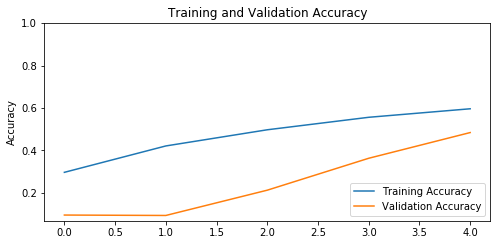

In [27]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.show()

In [ ]:
val_loss, val_accuracy = model.evaluate(ds_test, steps = validation_steps)
print("Test Loss is {}\nTest Accuracy is {}".format(val_loss,val_accuracy))

In [ ]:
import keras2onnx

In [ ]:
onnx_model = keras2onnx.convert_keras(model=model,name=model.name,target_opset=10)

In [ ]:
import os

In [ ]:
os.mkdir("./model_repo")

In [ ]:
os.mkdir("./model_repo/onnx")

In [ ]:
os.mkdir("./model_repo/onnx/1")

In [ ]:
keras2onnx.save_model(onnx_model, './model_repo/onnx/1/HE_resnet50.onnx')